Facebook Prophet is a sklearn-like library which implements a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It is known to work best with data which shows strong seasonality and has several seasons of history data.
Since all the store data had visible seasonality, we decided to evaluate the model for 18 time series of our project. Although there aren’t feature engineering steps involved in Prophet, we can specify tuning parameters for trend, seasonality and holidays (using Calendar.csv data)– three major capabilities Prophet is known to capture well. Prophet was seen to learn alot from the seasonality of the data and replicate a similar pattern in the forecasts. 


In [ ]:
#installations
!pip install prophet

In [ ]:
#all imports here
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from prophet.diagnostics import cross_validation
import itertools
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from datetime import datetime
from sklearn.metrics import mean_pinball_loss
rmsse_forecasted= {}


In [ ]:
#all system setup here
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/essec assignment/Forecasting/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title
def extract_id_info(id1):
    id_info= id1.split('_')
    state = id_info[1]
    category = id_info[0]
    return state,category


def select_snaps(df,id1):
    state, category = extract_id_info(id1)
    snap_days_CA = df[df['snap_CA']==1]['date'].unique()
    snap_days_TX = df[df['snap_TX']==1]['date'].unique()
    snap_days_WI = df[df['snap_TX']==1]['date'].unique()
    if state =='CA':
        return snap_days_CA
    elif state == 'TX':
        return snap_days_TX
    else:
        return snap_days_WI

def get_holidays(id1):
    calendar_data = pd.read_csv(file_path+"calendar.csv")
    Hol1_rel = calendar_data[calendar_data['event_type_1']=='Religious']['date'].unique()
    Hol1_nat = calendar_data[calendar_data['event_type_1']=='National']['date'].unique()
    Hol1_cul = calendar_data[calendar_data['event_type_1']=='Cultural']['date'].unique()
    Hol1_Sp = calendar_data[calendar_data['event_type_1']=='Sporting']['date'].unique()
    Hol2_rel = calendar_data[calendar_data['event_type_2']=='Religious']['date'].unique()
    Hol2_cul = calendar_data[calendar_data['event_type_2']=='Cultural']['date'].unique()    
    
    snap_days1 = pd.DataFrame({
      'holiday': 'snaps',
      'ds': pd.to_datetime(select_snaps(calendar_data, id1)),
      'lower_window': 0,
      'upper_window': 0,
    })
    
    holiday1_rel = pd.DataFrame({
      'holiday': 'holiday_religious',
      'ds': pd.to_datetime(Hol1_rel),
      'lower_window': -1,
      'upper_window': 1,
    })

    holiday1_cul = pd.DataFrame({
      'holiday': 'holiday_cultural',
      'ds': pd.to_datetime(Hol1_cul),
      'lower_window': -1,
      'upper_window': 1,
    })

    holiday1_nat = pd.DataFrame({
      'holiday': 'holiday_national',
      'ds': pd.to_datetime(Hol1_nat),
      'lower_window': -1,
      'upper_window': 1,
    })

    holiday2_cul = pd.DataFrame({
      'holiday': 'holiday_religious',
      'ds': pd.to_datetime(Hol2_cul),
      'lower_window': -1,
      'upper_window': 1,
    })

    holiday2_rel = pd.DataFrame({
      'holiday': 'holiday_religious',
      'ds': pd.to_datetime(Hol2_rel),
      'lower_window': -1,
      'upper_window': 1,
    })
        
    holidays =  pd.concat((snap_days1,holiday1_rel,holiday1_cul,holiday1_nat,holiday2_cul,holiday2_rel))
    return holidays

# get_holidays(columns_to_pick[1]).head(5)

In [ ]:
def rmsse(y_true: np.ndarray, y_pred: np.ndarray, y_hist: np.ndarray) -> float:
    h, n = len(y_true), len(y_hist)

    numerator = np.sum((y_true - y_pred)**2)
    denominator = 1/(n-1)*np.sum((y_hist[1:] - y_hist[:-1])**2)

    rmsse = np.sqrt(1/h * numerator/denominator)
    return rmsse

In [ ]:
def quantile_spl(train_y, valid_y, quantile_preds, quantile):
    train_y = train_y.astype(np.float32)
    valid_y = valid_y.astype(np.float32)
    quantile_preds = quantile_preds.astype(np.float32)
    
    loss = (
        ((valid_y-quantile_preds)*(valid_y>=quantile_preds)*quantile)
        +
        ((quantile_preds-valid_y)*(quantile_preds>valid_y)*(1-quantile))
    )
    loss = loss.sum()
    loss = loss/len(quantile_preds)
    scale = np.abs(np.diff(train_y)).mean()
    spl = loss/scale
    # replace inf with nan so that all subsequent computations work
    # spl[np.isinf(spl)] = np.nan
    # aggregated_spl = np.nanmean(spls)
    return spl

# quantile_spl(np.array([1,3,4]), np.array([3,2,2]), np.array([1,2,3]), 0.95)

In [ ]:
def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())
    params =[]
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df

def single_cv_run(history_df, metrics, param_dict, projectData_test):
    m = Prophet(**param_dict, holidays=get_holidays(column_to_forecast))
    # m.add_country_holidays(country_name='US')
    m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
    m.fit(history_df)

    #for 12 days point prediction
    df_cv = cross_validation(m, initial='1515 days', period='30 days', horizon = '28 days',parallel="processes")
    #selects the 25th row which has data for 28 days
    df_p = performance_metrics(df_cv)[25:]
    df_p['rmsse'] = rmsse(projectData_test['y'].to_numpy(), 
                              df_cv[-28:]['yhat'].to_numpy(), 
                              history_df[(projectData_train['y'] != 0)]['y'].to_numpy())
    df_p['params'] = str(param_dict)
    df_p = df_p[metrics]
    
    #particularly to check the prediction for 28 days only !!!!
    df_p['horizon'] = df_p['horizon'].astype(str)
    print(df_p['horizon'])
    # df_p = df_p[df_p['horizon'].str.contains("28")]
    # df_p = df_p.loc[:, metrics]
    return df_p


We  attune the hyper parameters to reach closer to the observed seasonalities and the change points  in the original time series. Hyper parameter tuning was done on all the parameters mentioned below and the parameters minimising the RMSSE value were chosen for the model and the prediction. The forecast contains predicted values - yhat, the upper and lower bound of the confidence interval (from the interval width provided) as yhat_upper and yhat_lower

**changepoint_prior_scale**:
 
Almost every time series has trend, and this parameter defines the flexibility to fit the trend

**seasonality_prior_scale**: 
This parameter controls the flexibility of the seasonality. Similarly, a large value allows the seasonality to fit large fluctuations, a small value shrinks the magnitude of the seasonality

**holidays_prior_scale**: 
As the seasonality, it estimates the fit of the holidays of the days leading to a holiday, as there can be multiple holidays for different reasons. Prophet has a separate attribute to take holidays

**seasonality_mode**: 
During EDA of multiple time series we noticed a few time series were multiplicative in nature. Hence this parameter to examine additive or multiplicative nature of the series

**weekly_seasonality**: 
We do see weekly seasonality in all the graphs for all the time series and hence this is set as just ‘True’

**yearly_seasonality**:
	Although the EDA specifies there is no such monthly pattern repeated, but there are annual seasons seen in the data, i.e. spring and December hobbies shopping for Hobbies data across all super market. Hence we set the value as ‘True’

**uncertainty_samples**:
	This is used to run the hyper parameter tuning grid search faster
interval_width	Prophet predict returns uncertainty intervals for each component, like yhat_lower and yhat_upper for the forecast yhat. These are computed as quantiles of the posterior predictive distribution, and interval_width specifies which quantiles to use. 



In [ ]:
# -------------THIS WHOLE PART OF THE CODE RUNS HYPER PARAMETER TUNING FOR POINT FORECAST ON RMSSE
# it generates the hyperparameters for 18 time series and writes them into a file (because it runs overnight and generates alot of logs)
#they are used in next steps to calculate error and forecast

for index in range(1,19):

  dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
  #all data reading here  
  projectData = pd.read_csv(file_path+"Projectdata.csv", date_parser=dateparse)
  projectData['date'] = pd.to_datetime(projectData.date, format='%Y-%m-%d')
  calendar_data = pd.read_csv(file_path+"calendar.csv", date_parser=dateparse)
  calendar_data['date'] = pd.to_datetime(calendar_data.date, format='%Y-%m-%d')

  all_columns = projectData.columns
  print(all_columns)
  column_to_forecast = all_columns[index]
  columns_to_pick = ["date", column_to_forecast]
  print(columns_to_pick)
  projectData = projectData[columns_to_pick]
  projectData.columns = ["ds","y"]

  #algorithms
  period_predict = 28
  print(projectData.shape[0])
  projectData['cap'] = projectData['y'].max()+100
  projectData_train = projectData[: projectData.shape[0]-period_predict]
  projectData_test = projectData[-period_predict:]

  print(projectData_train.shape)
  print(projectData_test.shape)

  param_grid = {  
                  'changepoint_prior_scale': [0.005, 0.05, 0.5, 5],
                  'seasonality_prior_scale':[0.1, 1, 10.0],
                  'holidays_prior_scale':[0.1, 1, 10.0],
                  'seasonality_mode': ['multiplicative', 'additive'],
                  'growth': ['linear', 'logistic'],
                  'weekly_seasonality': [True] ,
                  'yearly_seasonality': [True], 
                  'uncertainty_samples': [False]
                  # 'yearly_seasonality': [5, 10, 20]
                }

  # metrics = ['horizon', 'rmse', 'mape', 'params'] 
  metrics = ['horizon', 'rmse', 'params','rmsse'] 
  results = []
  params_df = create_param_combinations(**param_grid)
  print(params_df.shape)
  i = 0 

  for param in params_df.values:
      i+=1
      print(i)
      param_dict = dict(zip(params_df.keys(), param))
      print(param)
      cv_df = single_cv_run(projectData_train,  metrics, param_dict, projectData_test)
      results.append(cv_df)

  results_df = pd.concat(results).reset_index(drop=True)
  print("Minimim RMSE is:", min(results_df['rmsse']))
  best_param = results_df.loc[results_df['rmsse'] == min(results_df['rmsse']), ['params']]
  # best_param = results_df.loc[results_df['rmse'] == min(results_df['rmse']), ['params']]
  # best_param = results_df.loc[results_df['mape'] == min(results_df['mape']), ['params']]
  print(f'\n The best param combination is {best_param.values[0][0]}')

  f = open(file_path+"/tuning/"+column_to_forecast+".txt", "a")
  f.write(best_param.values[0][0])
  f.close()

In [ ]:
#---------------- RESULTS AND DATA AFTER HYPER PARAMETER TUNING AND CALCULATING PREDICTIONS

def do_the_forecasts(index,changepoint_prior_scale, seasonality_prior_scale,holidays_prior_scale,seasonality_mode,growth ):
  dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
  projectData = pd.read_csv(file_path+"Projectdata.csv", date_parser=dateparse)
  projectData['date'] = pd.to_datetime(projectData.date, format='%Y-%m-%d')
  calendar_data = pd.read_csv(file_path+"calendar.csv", date_parser=dateparse)
  calendar_data['date'] = pd.to_datetime(calendar_data.date, format='%Y-%m-%d')

  all_columns = projectData.columns
  column_to_forecast = all_columns[index]
  columns_to_pick = ["date", column_to_forecast]
  print(columns_to_pick)
  projectData = projectData[columns_to_pick]
  projectData.columns = ["ds","y"]

  #algorithms
  period_predict = 28
  projectData['cap'] = projectData['y'].max()+100
  projectData_train = projectData[: projectData.shape[0]-period_predict]
  projectData_test = projectData[-period_predict:]

  m = Prophet(
      changepoint_prior_scale=changepoint_prior_scale,
      seasonality_prior_scale=seasonality_prior_scale,
      holidays_prior_scale= holidays_prior_scale,
      seasonality_mode=seasonality_mode,
      growth=growth, 
      mcmc_samples=0,
      weekly_seasonality=True ,
      yearly_seasonality=True, 
      uncertainty_samples=False,
      holidays=get_holidays(columns_to_pick[1]))
  # .add_seasonality(name="weekly", period=7, fourier_order=7).add_seasonality(name="yearly", period=365.25, fourier_order=14)

  m.fit(projectData)
  future = m.make_future_dataframe(periods=28) 
  future['cap'] = projectData['y'].max()+100
  future['floor'] = 0
  forecast = m.predict(future)
  fig21 = m.plot(forecast)
  fig22 = m.plot_components(forecast)

  #testing
  # #plotting actual forecast with predicted forecast
  f, ax = plt.subplots(figsize=(14,5))
  f.set_figheight(5)
  f.set_figwidth(15)
  projectData_test.plot(kind='line',x='ds', y='y', color='green', label='Test', ax=ax)
  forecast[-period_predict:].plot(kind='line',x='ds',y='yhat', color='red',label='Forecast', ax=ax)
  plt.title('Forecast and Actuals')
  plt.show()

  pinball_loss = []

  for alpha in [0.5,0.67,0.95,0.99]:
      m = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale= holidays_prior_scale,
        seasonality_mode=seasonality_mode,
        growth=growth, 
        mcmc_samples=0,
        weekly_seasonality=True ,
        yearly_seasonality=True, 
        daily_seasonality=False,
        holidays=get_holidays(columns_to_pick[1]), 
        interval_width = alpha
        )
      # .add_seasonality(name="weekly", period=7, fourier_order=3).add_seasonality(name="yearly", period=365.25, fourier_order=15)

      m.fit(projectData_train)
      future = m.make_future_dataframe(periods=28) 
      future['cap'] = projectData_test['y'].max()+100
      future['floor'] = 0
      forecast = m.predict(future)
      pinball_loss.append(quantile_spl(projectData_train["y"].to_numpy(), projectData_test["y"].to_numpy(), 
                                      forecast[-period_predict:]['yhat_lower'].to_numpy(), alpha))
      pinball_loss.append(quantile_spl(projectData_train["y"].to_numpy(), projectData_test["y"].to_numpy(), 
                                      forecast[-period_predict:]['yhat_upper'].to_numpy(), alpha))
      if alpha == 0.95:
        rmsse_forecasted[column_to_forecast] = (rmsse(projectData_test['y'].to_numpy(), forecast[-period_predict:]['yhat'].to_numpy(), 
                                projectData_train[(projectData_train['y'] != 0)]['y'].to_numpy()))

  pinball_loss.append(quantile_spl(projectData_train["y"].to_numpy(), projectData_test["y"].to_numpy(), 
                                  forecast[-period_predict:]['yhat'].to_numpy(), 0.5))

  print("Total Pinball Loss ", (pinball_loss))
  print("Avg Pinball Loss ", np.mean(pinball_loss))
  print("RMSSE: ",rmsse_forecasted[column_to_forecast])


In [ ]:
#---------------- RESULTS AND DATA AFTER HYPER PARAMETER TUNING AND CALCULATING PREDICTIONS

def do_the_forecasts_fourier(index, changepoint_prior_scale, seasonality_prior_scale,holidays_prior_scale,seasonality_mode,growth,
                             weekly_fourier_order, yearly_fourier_order):
  dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
  projectData = pd.read_csv(file_path+"Projectdata.csv", date_parser=dateparse)
  projectData['date'] = pd.to_datetime(projectData.date, format='%Y-%m-%d')
  calendar_data = pd.read_csv(file_path+"calendar.csv", date_parser=dateparse)
  calendar_data['date'] = pd.to_datetime(calendar_data.date, format='%Y-%m-%d')

  all_columns = projectData.columns
  column_to_forecast = all_columns[index]
  columns_to_pick = ["date", column_to_forecast]
  print(columns_to_pick)
  projectData = projectData[columns_to_pick]
  projectData.columns = ["ds","y"]

  #algorithms
  period_predict = 28
  projectData['cap'] = projectData['y'].max()+100
  projectData_train = projectData[: projectData.shape[0]-period_predict]
  projectData_test = projectData[-period_predict:]

  m = Prophet(
      changepoint_prior_scale=changepoint_prior_scale,
      seasonality_prior_scale=seasonality_prior_scale,
      holidays_prior_scale= holidays_prior_scale,
      seasonality_mode=seasonality_mode,
      growth=growth, 
      mcmc_samples=0,
      weekly_seasonality=False ,
      yearly_seasonality=False, 
      uncertainty_samples=False,
      holidays=get_holidays(columns_to_pick[1]))
  m.add_seasonality(name="weekly", period=7, fourier_order=weekly_fourier_order)
  m.add_seasonality(name="yearly", period=365.25, fourier_order=yearly_fourier_order)

  m.fit(projectData)
  future = m.make_future_dataframe(periods=28) 
  future['cap'] = projectData['y'].max()+100
  future['floor'] = 0
  forecast = m.predict(future)
  fig21 = m.plot(forecast)
  fig22 = m.plot_components(forecast)

  #testing
  # #plotting actual forecast with predicted forecast
  f, ax = plt.subplots(figsize=(14,5))
  f.set_figheight(5)
  f.set_figwidth(15)
  projectData_test.plot(kind='line',x='ds', y='y', color='green', label='Test', ax=ax)
  forecast[-period_predict:].plot(kind='line',x='ds',y='yhat', color='red',label='Forecast', ax=ax)
  plt.title('Forecast and Actuals')
  plt.show()

  pinball_loss = []

  for alpha in [0.5,0.67,0.95,0.99]:
      m = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale= holidays_prior_scale,
        seasonality_mode=seasonality_mode,
        growth=growth, 
        mcmc_samples=0,
        weekly_seasonality=False ,
        yearly_seasonality=False, 
        daily_seasonality=False,
        holidays=get_holidays(columns_to_pick[1]), 
        interval_width = alpha
        )
      
      m.add_seasonality(name="weekly", period=7, fourier_order=weekly_fourier_order)
      m.add_seasonality(name="yearly", period=365.25, fourier_order=yearly_fourier_order)

      m.fit(projectData_train)
      future = m.make_future_dataframe(periods=28) 
      future['cap'] = projectData_test['y'].max()+100
      future['floor'] = 0
      forecast = m.predict(future)
      pinball_loss.append(quantile_spl(projectData_train["y"].to_numpy(), projectData_test["y"].to_numpy(), 
                                      forecast[-period_predict:]['yhat_lower'].to_numpy(), alpha))
      pinball_loss.append(quantile_spl(projectData_train["y"].to_numpy(), projectData_test["y"].to_numpy(), 
                                      forecast[-period_predict:]['yhat_upper'].to_numpy(), alpha))
      if alpha == 0.95:
        rmsse_forecasted[column_to_forecast] = (rmsse(projectData_test['y'].to_numpy(), forecast[-period_predict:]['yhat'].to_numpy(), 
                                projectData_train[(projectData_train['y'] != 0)]['y'].to_numpy()))

  pinball_loss.append(quantile_spl(projectData_train["y"].to_numpy(), projectData_test["y"].to_numpy(), 
                                  forecast[-period_predict:]['yhat'].to_numpy(), 0.5))

  print("Total Pinball Loss ", (pinball_loss))
  print("Avg Pinball Loss ", np.mean(pinball_loss))
  print("RMSSE: ",rmsse_forecasted[column_to_forecast])


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['date', 'Hobbies_CA_1']


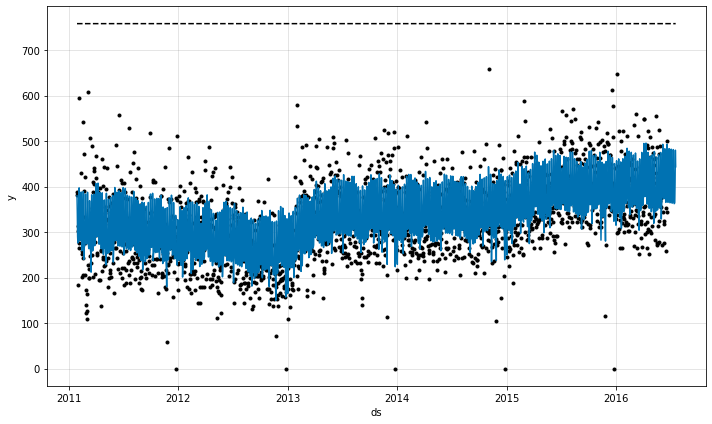

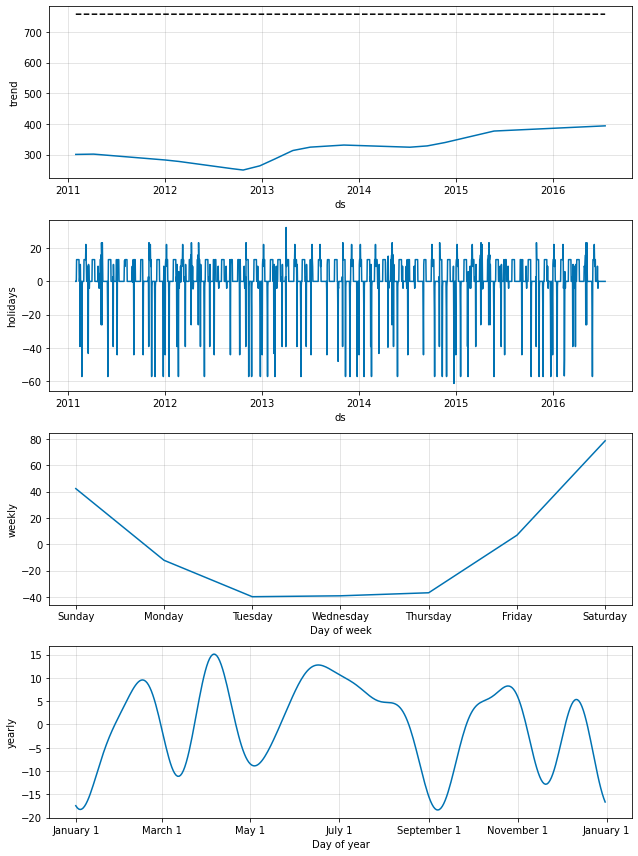

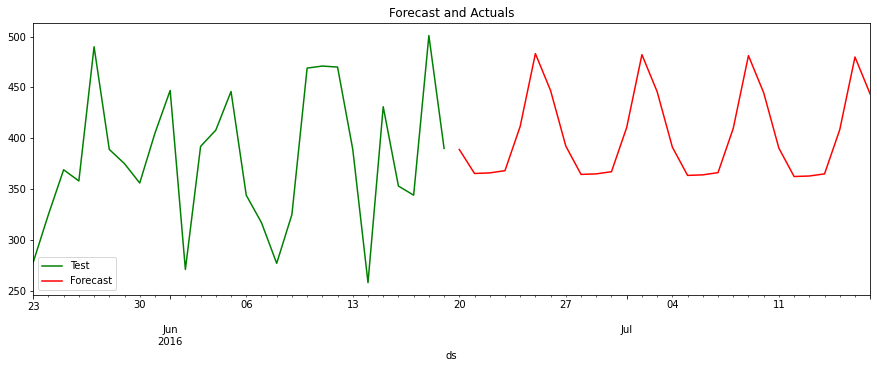

Total Pinball Loss  [0.6062729746703338, 0.3443821595910201, 0.9952114939690339, 0.3190305014142328, 2.215955277296253, 0.08322272004797913, 2.8341352526632706, 0.016588590276372002, 0.40497090151405774]
Avg Pinball Loss  0.8688633190491726
RMSSE:  0.8052249820593735


In [ ]:
do_the_forecasts(1,
  changepoint_prior_scale=0.5,
  seasonality_prior_scale=0.1,
  holidays_prior_scale= 10,
  seasonality_mode='additive',
  growth='logistic')

# Hobbies_CA_1
# Avg Pinball Loss  0.8688633190491726
# RMSSE:  0.8052249820593735

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['date', 'Household_1_CA_1']


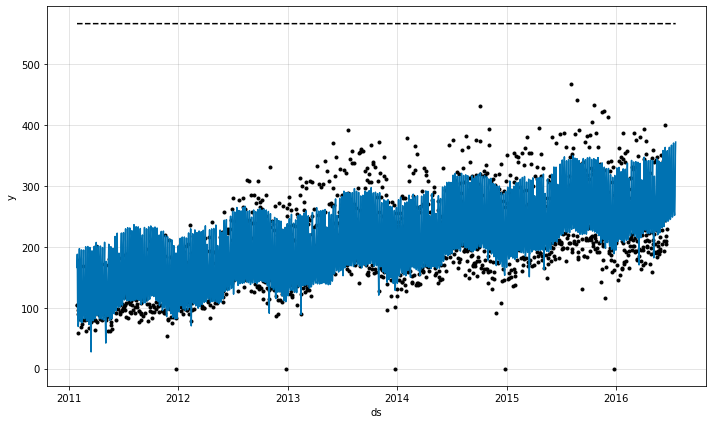

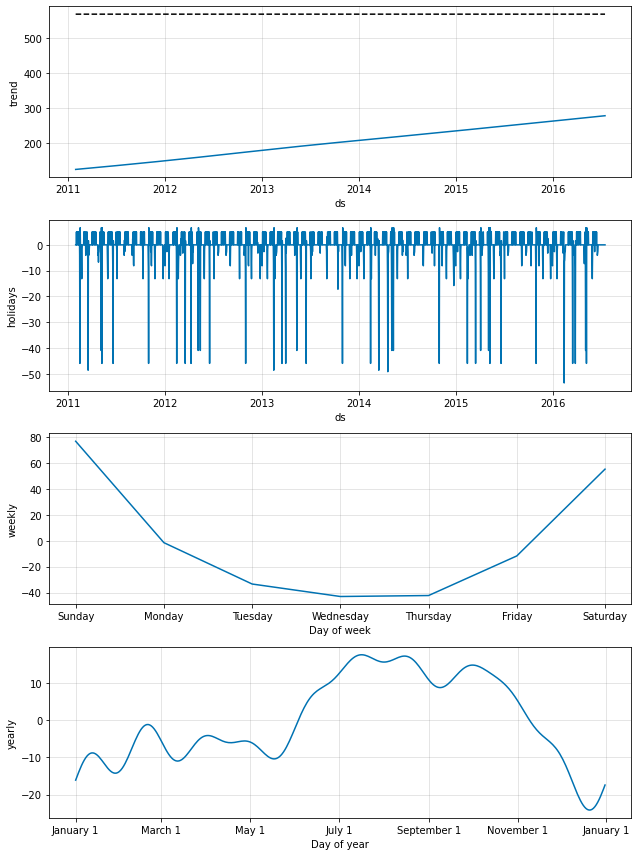

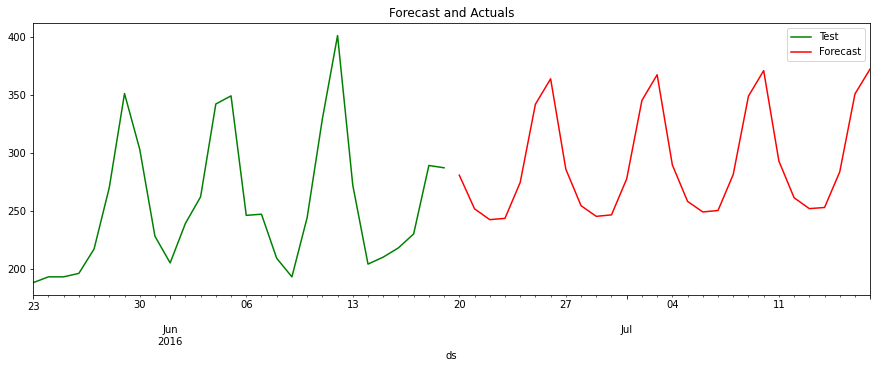

Total Pinball Loss  [0.35387338316841427, 0.31956768062326046, 0.5912431347675398, 0.2758614304843285, 1.5131239988799718, 0.07690214176014108, 2.042532368529995, 0.017686385821753012, 0.24800762847356067]
Avg Pinball Loss  0.6043109058343294
RMSSE:  0.5083417074803112


In [ ]:
do_the_forecasts(2,
  changepoint_prior_scale=0.005,
  seasonality_prior_scale=0.1,
  holidays_prior_scale= 10,
  seasonality_mode='additive',
  growth='logistic')

# Household_1_CA_1
# Avg Pinball Loss  0.6043109058343294
# RMSSE:  0.5083417074803112

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['date', 'Household_2_CA_1']


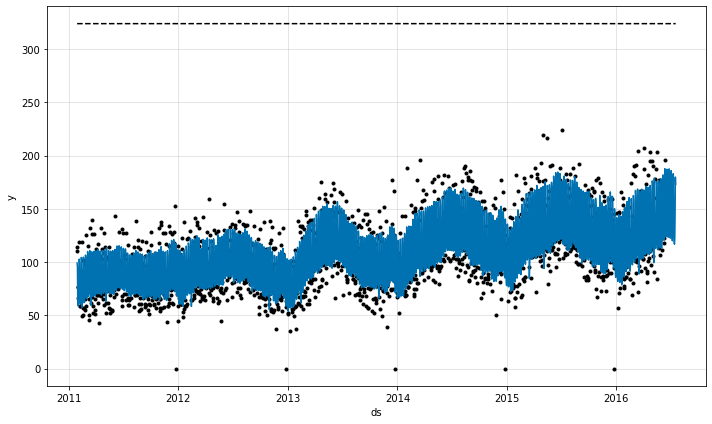

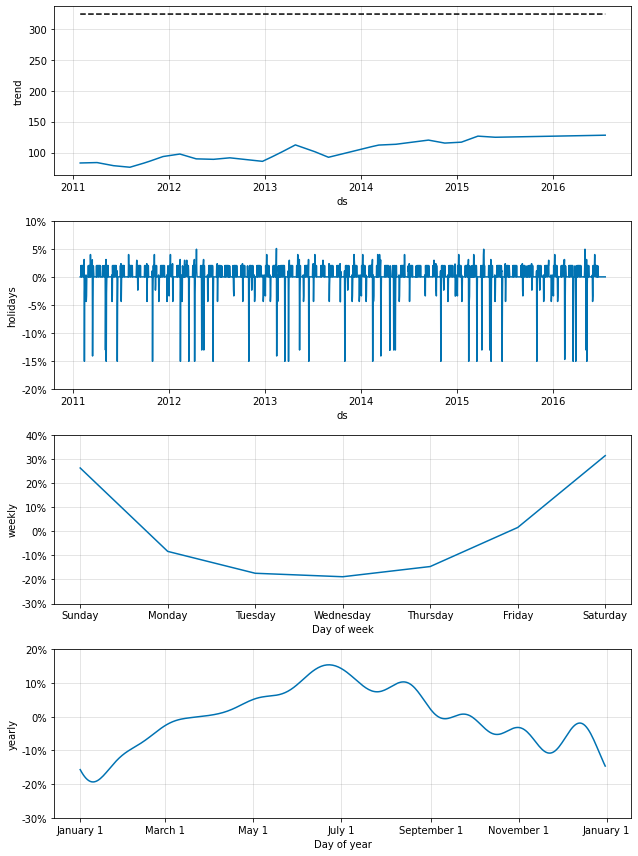

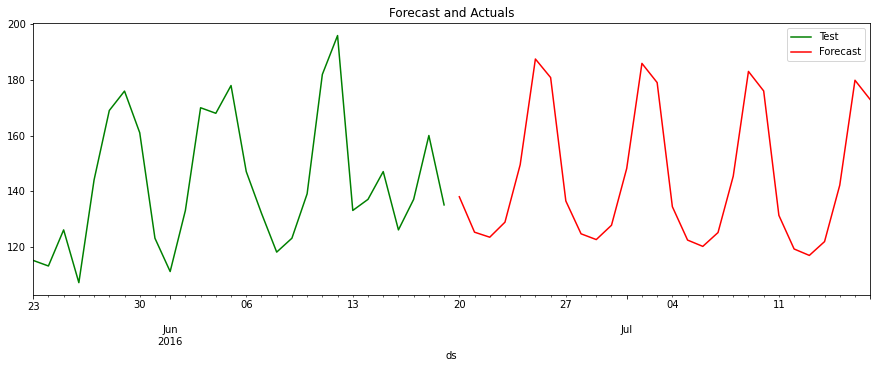

Total Pinball Loss  [0.5768713170054273, 0.26703631688015583, 0.8951410121742931, 0.25733545460481017, 1.863856814683417, 0.09126233432425822, 2.3639152283242657, 0.028678611583790935, 0.374269462022405]
Avg Pinball Loss  0.7464851724003138
RMSSE:  0.7302085106322814


In [119]:
do_the_forecasts(3,
  changepoint_prior_scale=5.0,
  seasonality_prior_scale=1,
  holidays_prior_scale= 10,
  seasonality_mode='multiplicative',
  growth='logistic')


# Household_2_CA_1
# Avg Pinball Loss  0.74421556490198
# RMSSE:  0.7302085106322814

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['date', 'Foods_1_CA_1']


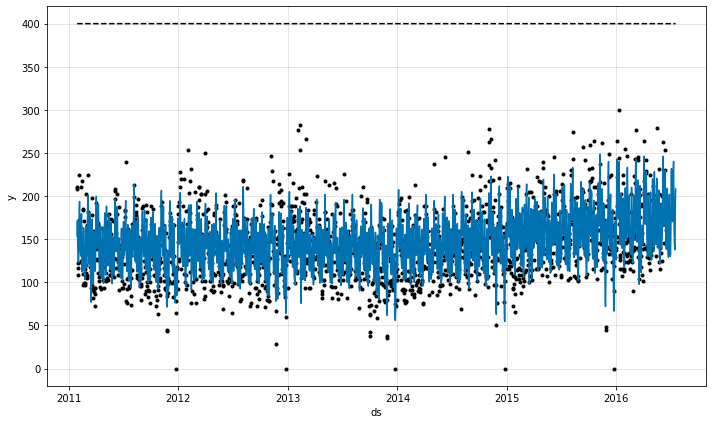

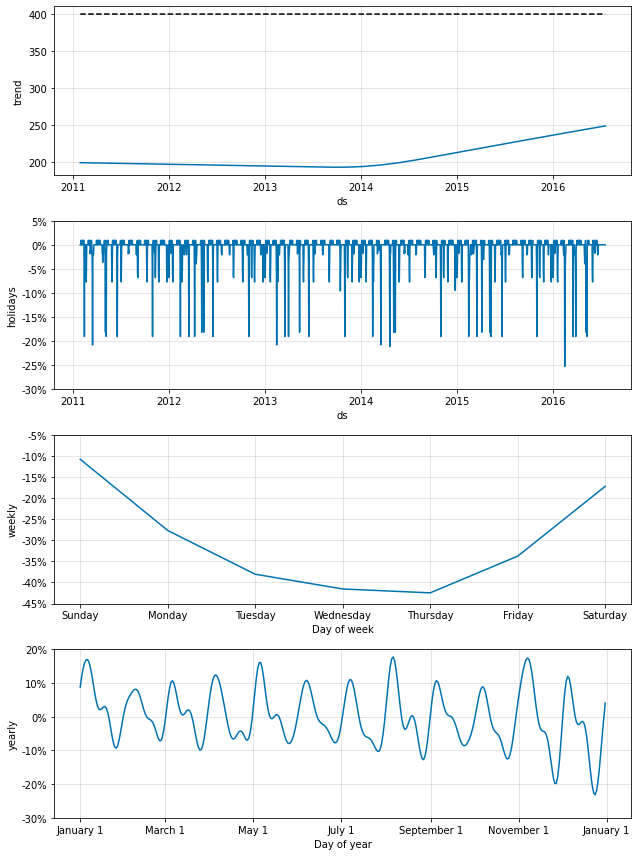

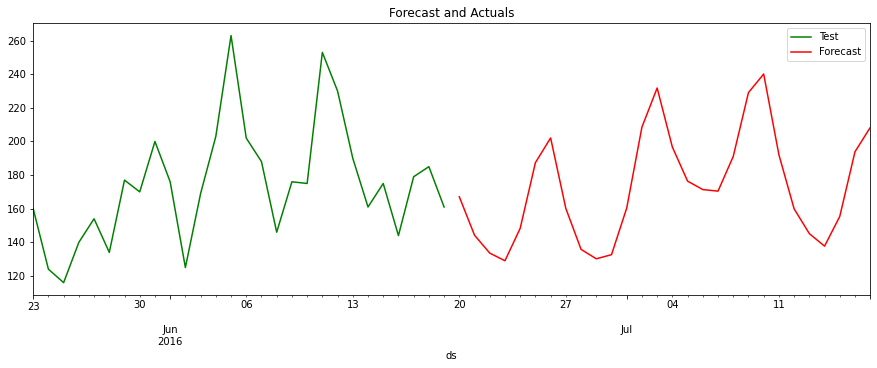

Total Pinball Loss  [0.6373890058388771, 0.3246261570559379, 0.9793199402328655, 0.29444125792725884, 2.1473023107644775, 0.09915445714633368, 2.649194509979989, 0.031170312521828555, 0.415004331256438]
Avg Pinball Loss  0.8419558091915562
RMSSE:  0.8235765084175849


In [ ]:
do_the_forecasts_fourier(4,
  changepoint_prior_scale=0.05,
  seasonality_prior_scale=0.1,
  holidays_prior_scale=0.1,
  seasonality_mode='multiplicative',
  growth='logistic',
  weekly_fourier_order = 7,
  yearly_fourier_order = 35)

# Foods_1_CA_1
# Avg Pinball Loss  0.8419558091915562
# RMSSE:  0.8235765084175849

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['date', 'Foods_2_CA_1']


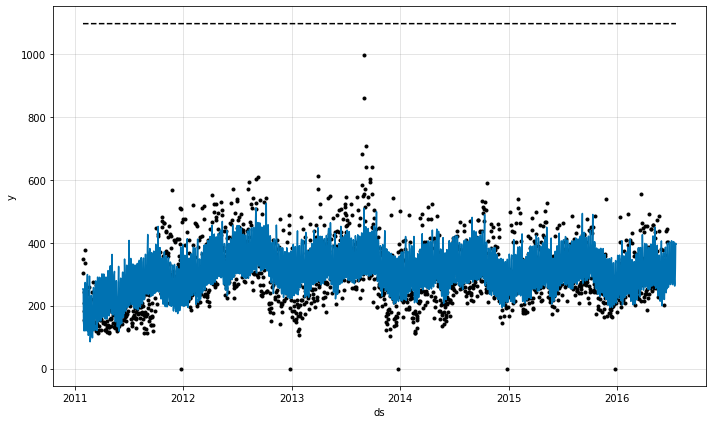

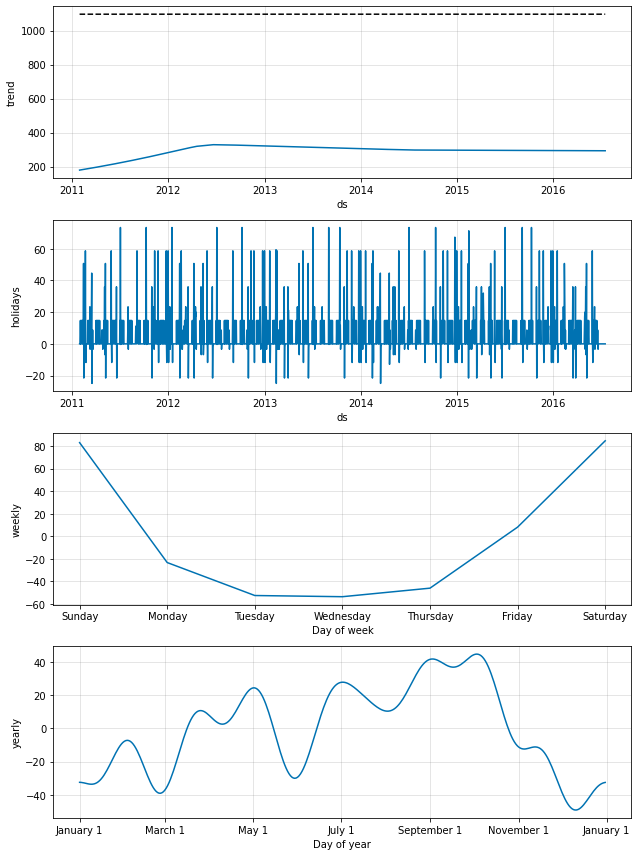

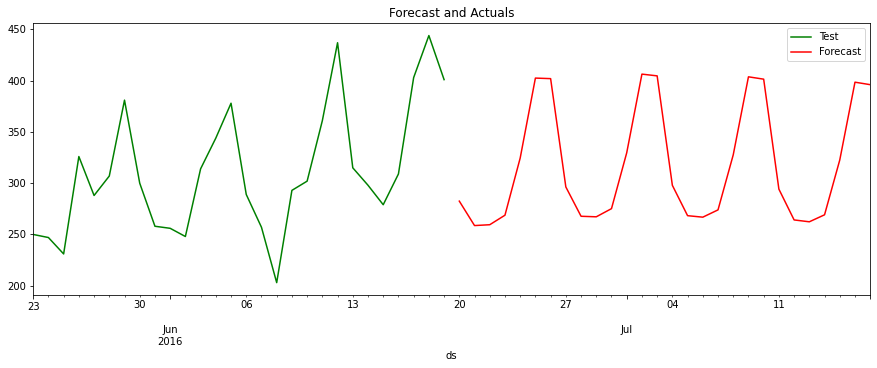

Total Pinball Loss  [1.7770107752145128, 1.0631826191769898, 2.607300248627744, 1.204687408007273, 4.652496877400149, 0.737537986314715, 5.534627854278286, 0.26174502418661455, 1.4200915314914164]
Avg Pinball Loss  2.1398533694108557
RMSSE:  2.1927812452417808


In [ ]:
do_the_forecasts(5,
  changepoint_prior_scale=0.05,
  seasonality_prior_scale=10,
  holidays_prior_scale= 0.1,
  seasonality_mode='additive',
  growth='logistic')

# Foods_2_CA_1
# Avg Pinball Loss  2.1398533694108557
# RMSSE:  2.1927812452417808

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['date', 'Foods_3_CA_1']


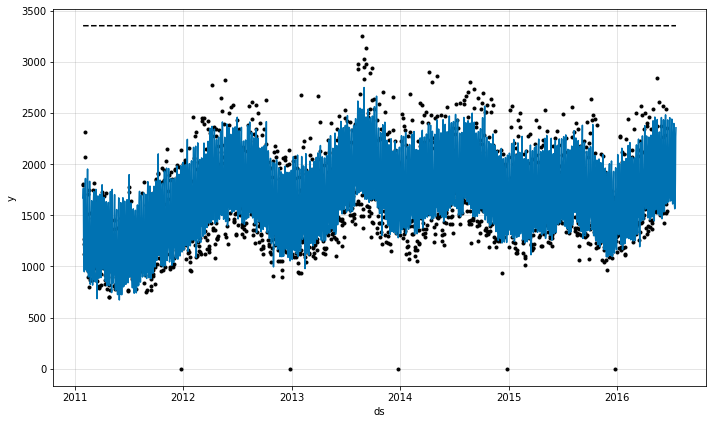

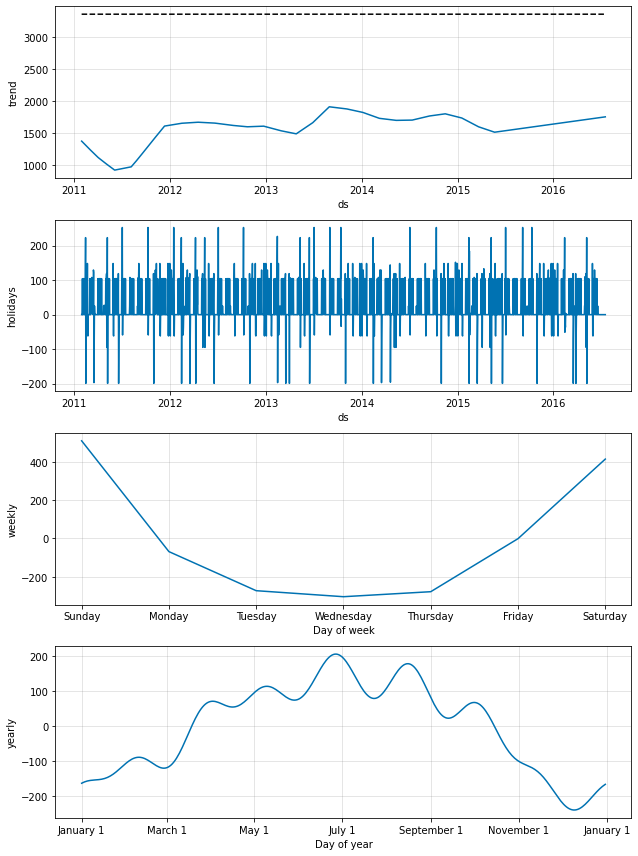

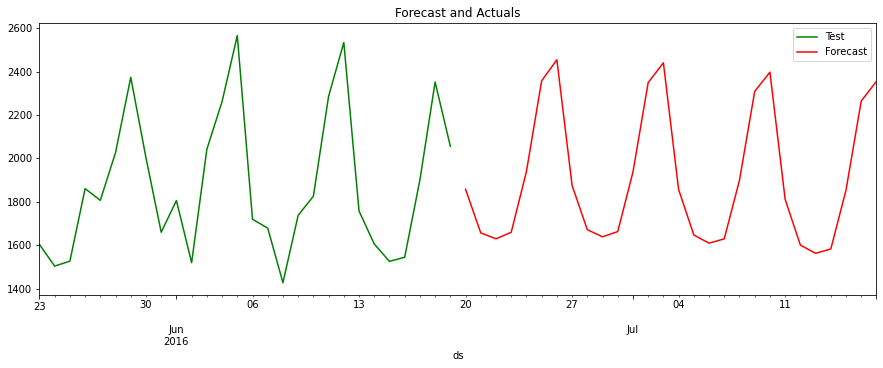

Total Pinball Loss  [0.9027777012659033, 0.4502200127093937, 1.3481340705191975, 0.465870534553317, 2.5784565794528866, 0.18331819649094944, 3.094834247635639, 0.09057605285738828, 0.6687207140376658]
Avg Pinball Loss  1.0869897899469265
RMSSE:  1.129122368458403


In [ ]:
do_the_forecasts(6,
  changepoint_prior_scale=5.0,
  seasonality_prior_scale=10,
  holidays_prior_scale= 0.1,
  seasonality_mode='additive',
  growth='logistic')

# Foods_3_CA_1
# Avg Pinball Loss  1.0869897899469265
# RMSSE:  1.129122368458403

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['date', 'Hobbies_CA_2']


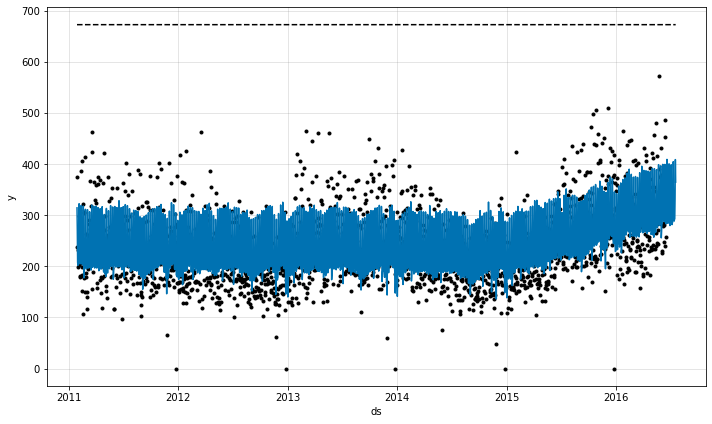

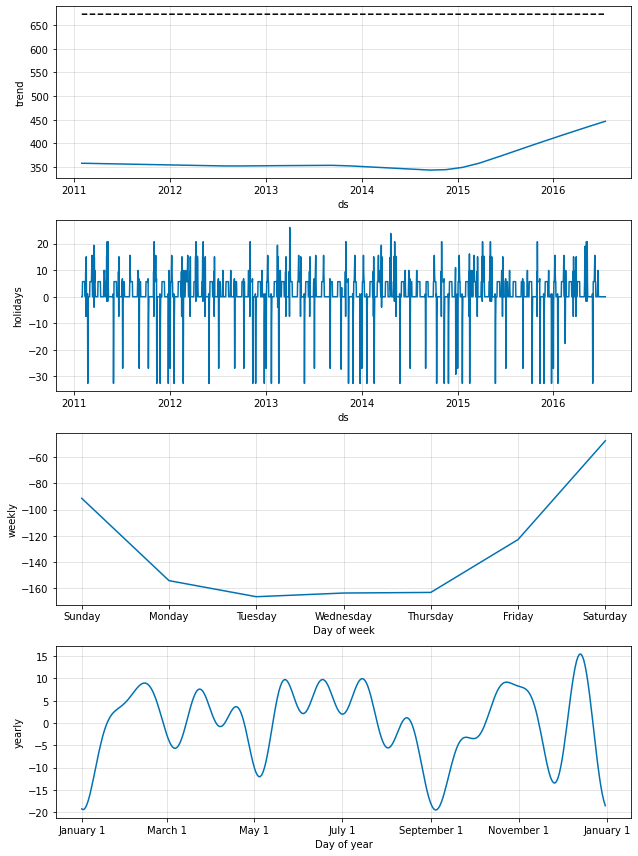

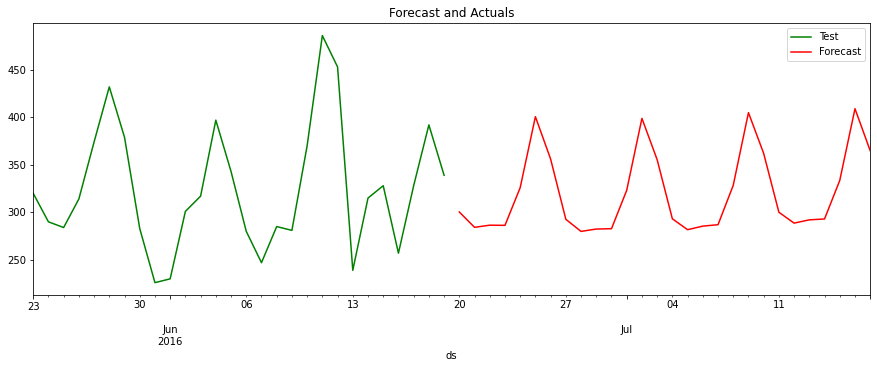

Total Pinball Loss  [0.7767845290985452, 0.29437135410785986, 1.21428419599209, 0.2864890722943795, 2.4990891626664404, 0.08940594276248016, 3.152948268690676, 0.028593105683940443, 0.4943552575081971]
Avg Pinball Loss  0.9818134320894009
RMSSE:  0.9130303216230614


In [ ]:
do_the_forecasts_fourier(7,
  changepoint_prior_scale=0.05,
  seasonality_prior_scale=1,
  holidays_prior_scale= 0.1,
  seasonality_mode='additive',
  growth='logistic',
  weekly_fourier_order = 7,
  yearly_fourier_order = 14)


# Hobbies_CA_2
# Avg Pinball Loss  0.9818134320894009
# RMSSE:  0.9130303216230614

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['date', 'Household_1_CA_2']


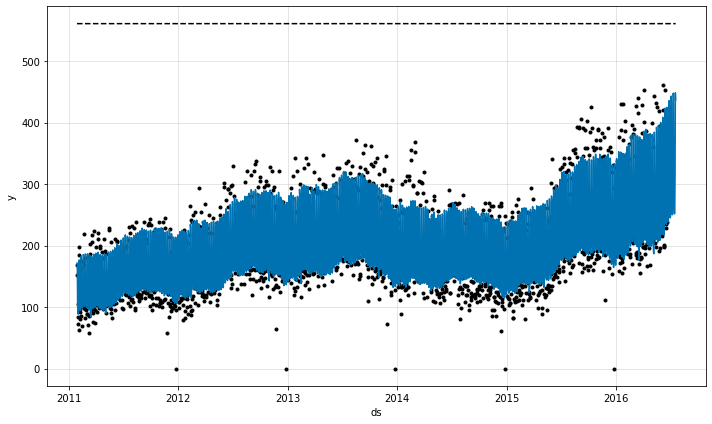

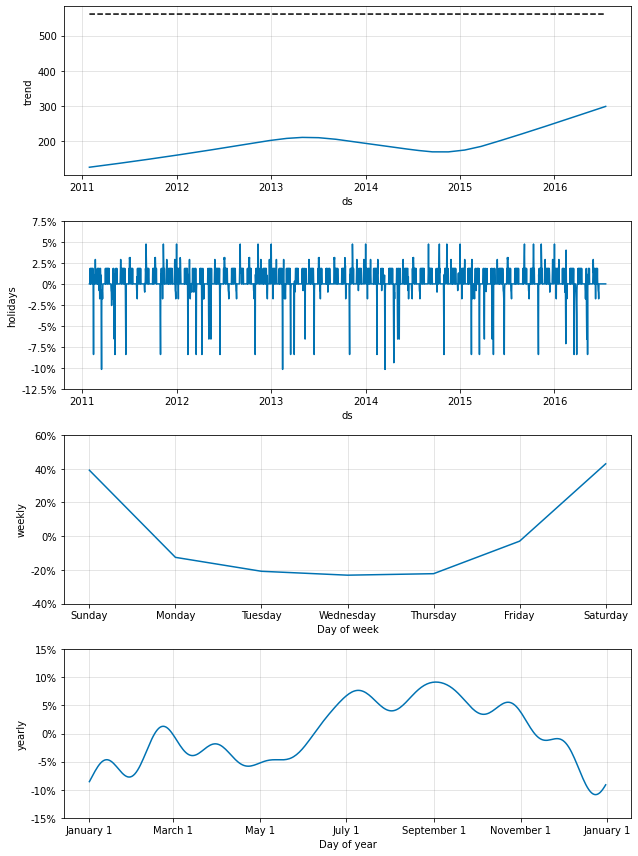

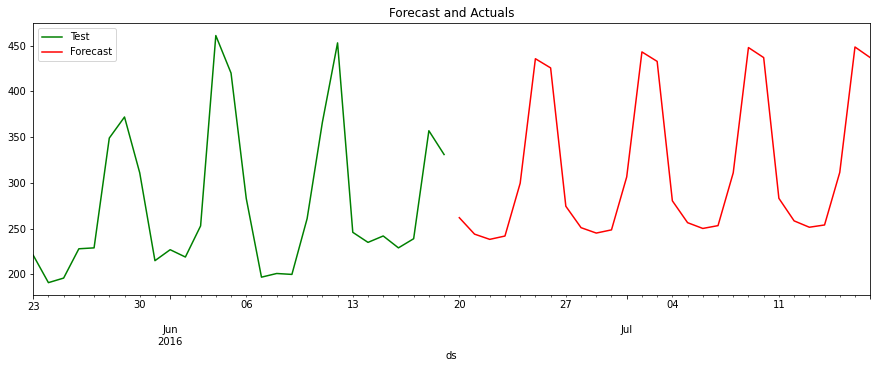

Total Pinball Loss  [0.29227583133147783, 0.502417494036927, 0.3186852536567411, 0.3886195998868049, 0.767791722104555, 0.08566173432293064, 1.1057923608066167, 0.020775143820002586, 0.364452090065768]
Avg Pinball Loss  0.42738569222575823
RMSSE:  0.672877449298942


In [ ]:
do_the_forecasts(8,
  changepoint_prior_scale=0.05,
  seasonality_prior_scale=10,
  holidays_prior_scale= 0.1,
  seasonality_mode='multiplicative',
  growth='logistic')

# Household_1_CA_2
# Avg Pinball Loss  0.42738569222575823
# RMSSE:  0.672877449298942

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['date', 'Household_2_CA_2']


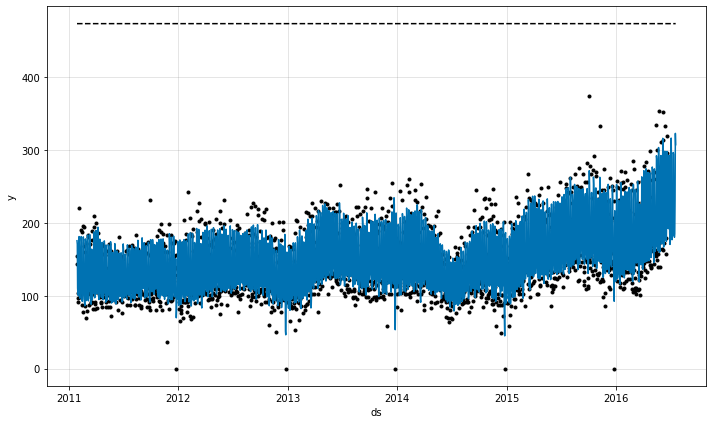

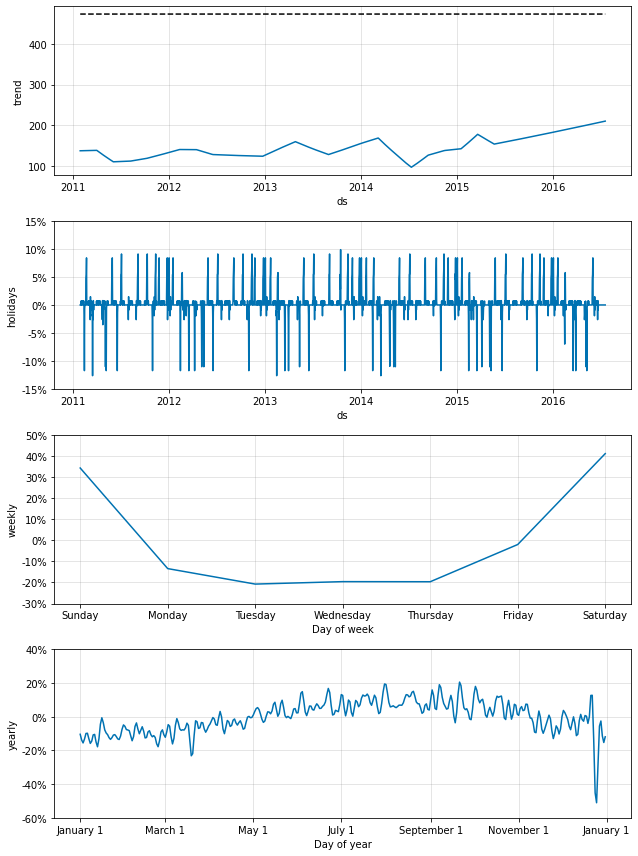

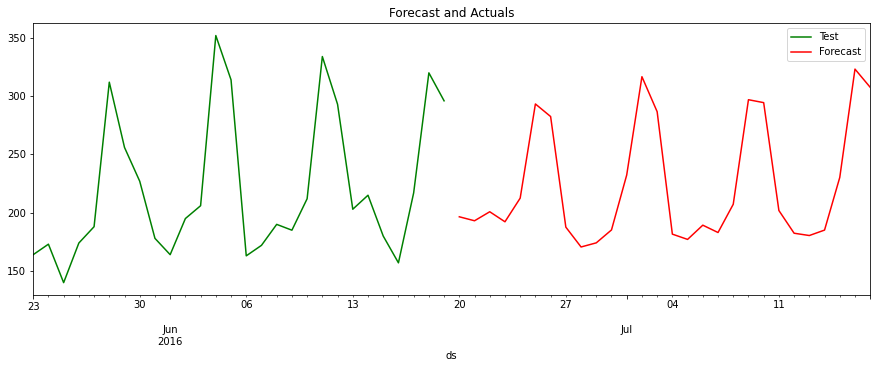

Total Pinball Loss  [0.653740485673579, 0.3449401610213654, 0.9901620930055376, 0.37432381461344844, 1.9514203769013203, 0.21011184012192605, 2.3831780341613853, 0.09279457315164365, 0.47436472467217594]
Avg Pinball Loss  0.8305595670358202
RMSSE:  0.865629228531887


In [ ]:
do_the_forecasts_fourier(9,
  changepoint_prior_scale=5,
  seasonality_prior_scale=0.1,
  holidays_prior_scale= 0.1,
  seasonality_mode='multiplicative',
  growth='logistic',
  weekly_fourier_order = 3,
  yearly_fourier_order = 90)


# Household_2_CA_2
# Avg Pinball Loss  0.8305595670358202
# RMSSE:  0.865629228531887

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['date', 'Foods_2_CA_2']


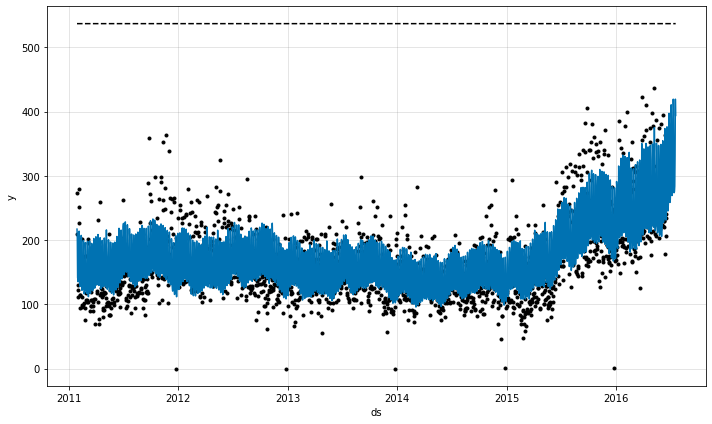

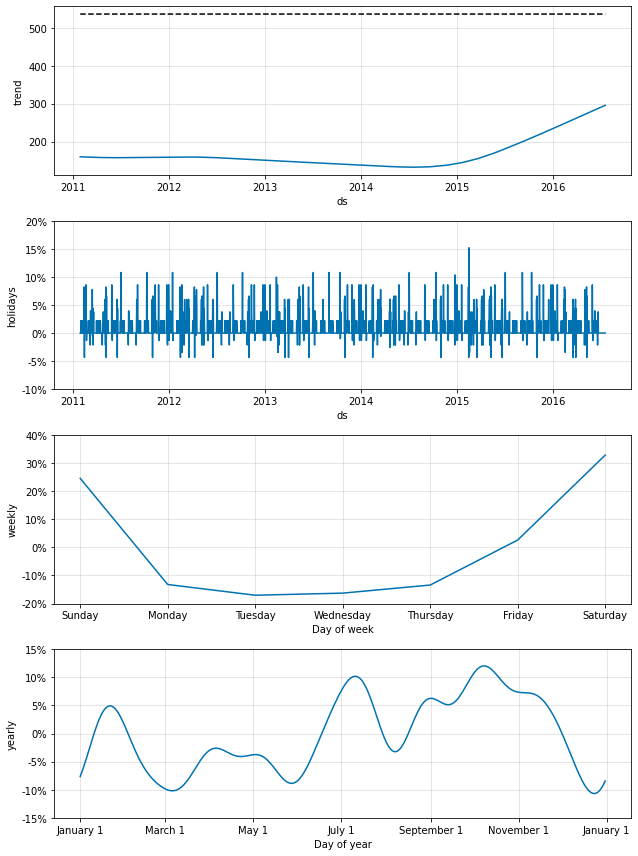

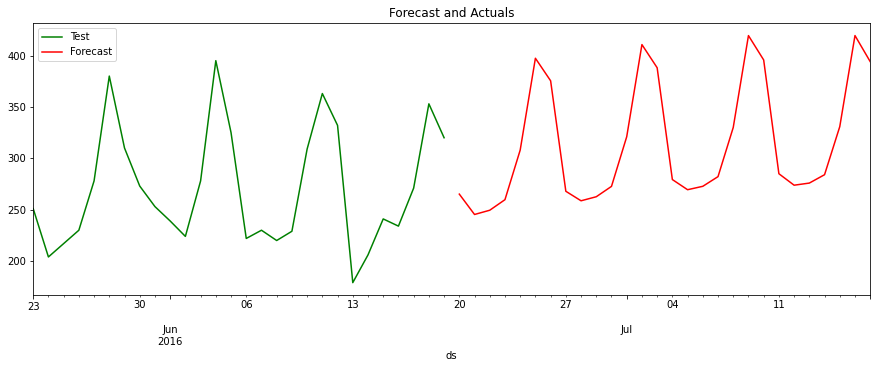

Total Pinball Loss  [0.6106336993439706, 0.33991348832215834, 0.9872745932182495, 0.3233315888650915, 2.2322843435478887, 0.07529259455997456, 2.8879277812327127, 0.01853193166643853, 0.38351904012505744]
Avg Pinball Loss  0.8731898956535047
RMSSE:  0.7334666215177434


In [ ]:
do_the_forecasts(11,
  changepoint_prior_scale=0.05,
  seasonality_prior_scale=0.1,
  holidays_prior_scale= 0.1,
  seasonality_mode='multiplicative',
  growth='logistic')


# Foods_2_CA_2
# Avg Pinball Loss  0.8731898956535047
# RMSSE:  0.7334666215177434

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['date', 'Foods_2_CA_2']


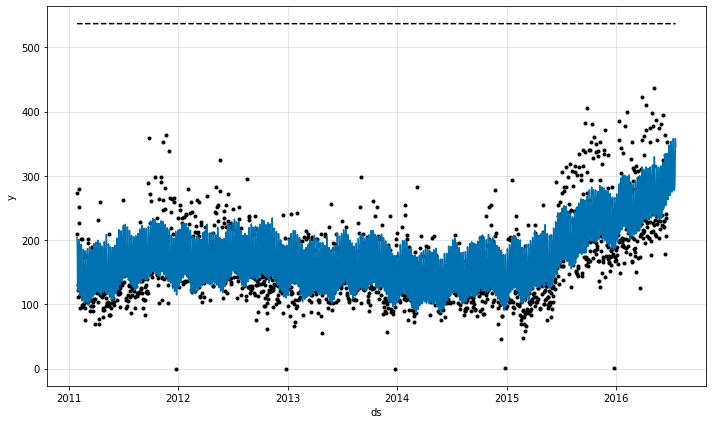

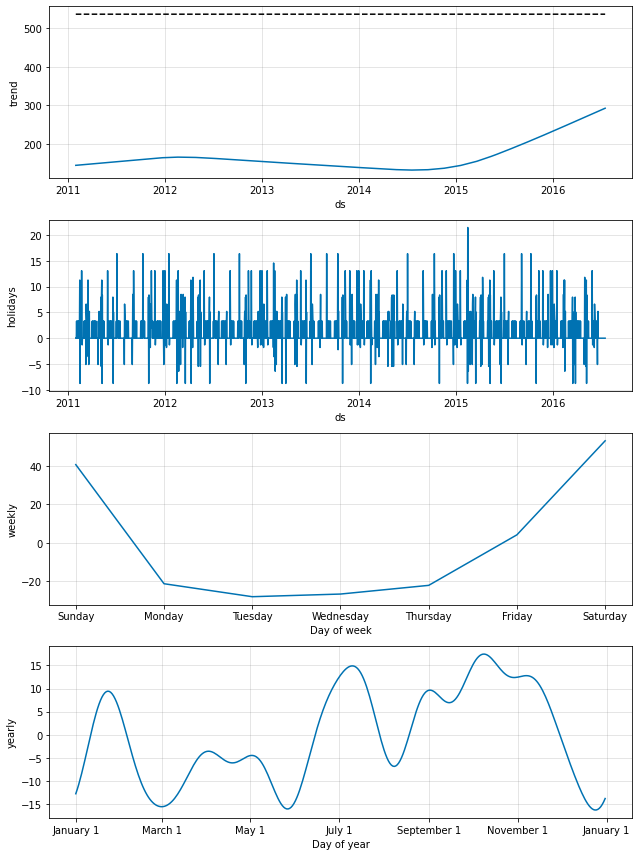

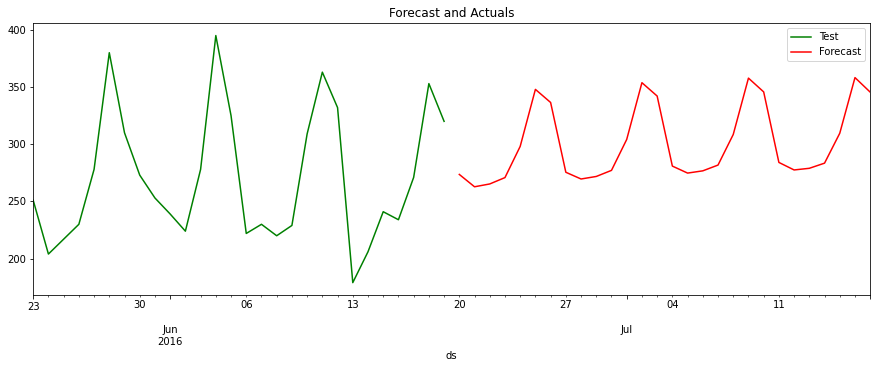

Total Pinball Loss  [0.6249863140516991, 0.3615778536914355, 0.9928465013111386, 0.3220088661267137, 2.248033531914582, 0.12013372561439756, 2.879684531885719, 0.024526643023382356, 0.377249025034473]
Avg Pinball Loss  0.8834496658503935
RMSSE:  0.7576223255441871


In [120]:
do_the_forecasts(11,
  changepoint_prior_scale=0.05,
  seasonality_prior_scale=1,
  holidays_prior_scale= 0.1,
  seasonality_mode='additive',
  growth='logistic')

# Foods_2_CA_2
# Avg Pinball Loss  0.8834496658503935
# RMSSE:  0.7576223255441871

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['date', 'Foods_3_CA_2']


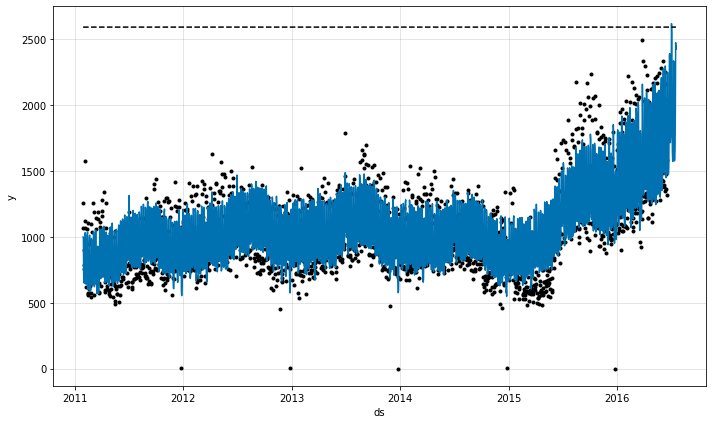

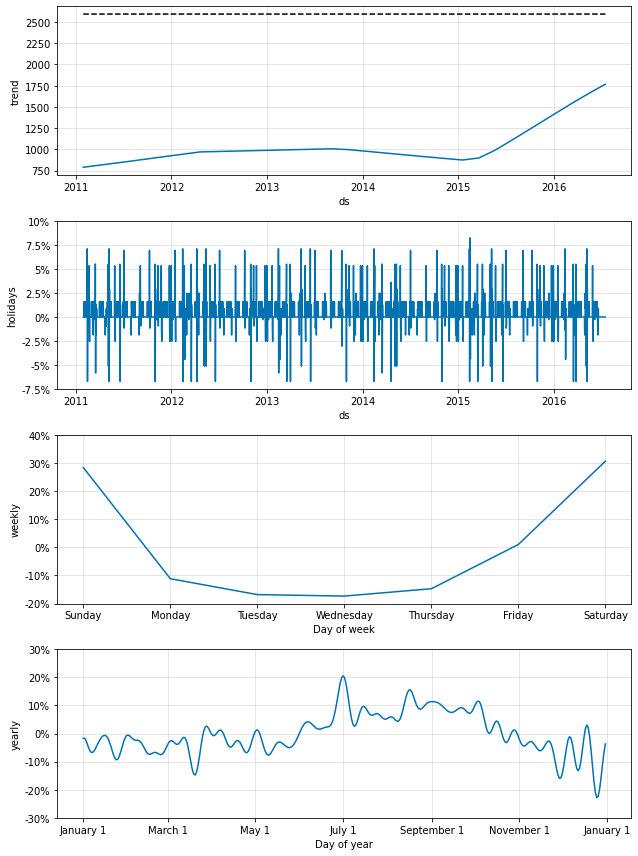

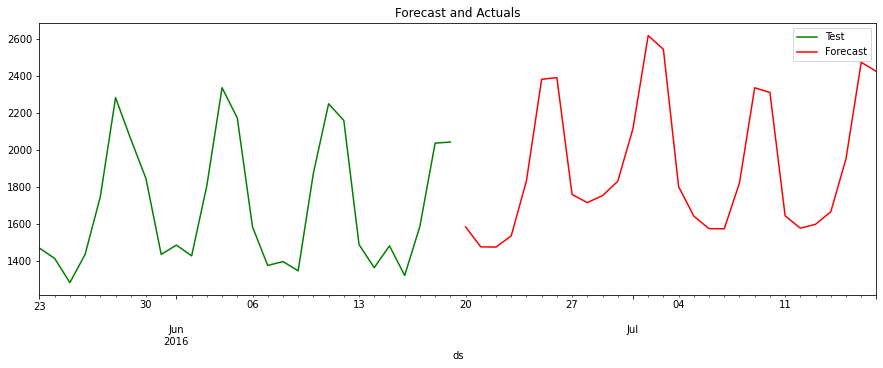

Total Pinball Loss  [0.49079374807108983, 0.3921439854813501, 0.7296376993225814, 0.33953980531778216, 1.6880865975274464, 0.11875442686097172, 2.1959036514898598, 0.052339847430174495, 0.38100899704983665]
Avg Pinball Loss  0.7098009731723436
RMSSE:  0.6908203457226707


In [ ]:
do_the_forecasts_fourier(12,
  changepoint_prior_scale=0.05,
  seasonality_prior_scale=0.1,
  holidays_prior_scale= 0.1,
  seasonality_mode='multiplicative',
  growth='logistic',
  weekly_fourier_order = 3,
  yearly_fourier_order = 35)

# Foods_3_CA_2
# Avg Pinball Loss  0.7098009731723436
# RMSSE:  0.6908203457226707

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['date', 'Hobbies_CA_3']


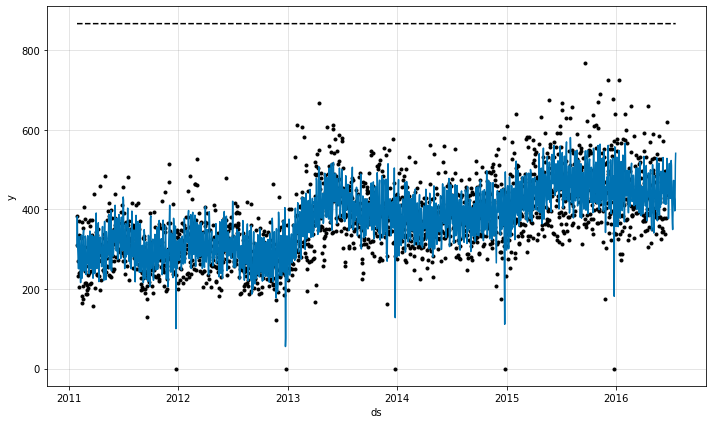

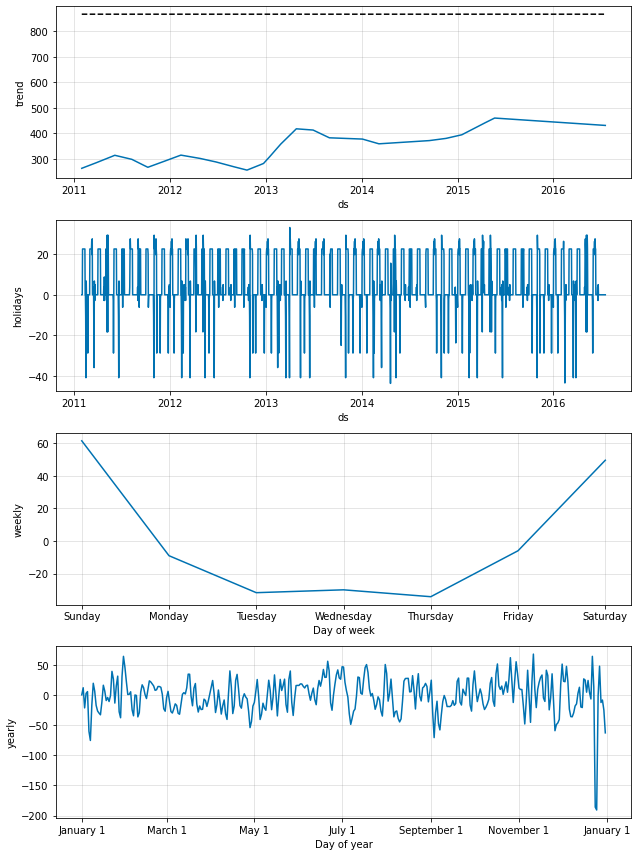

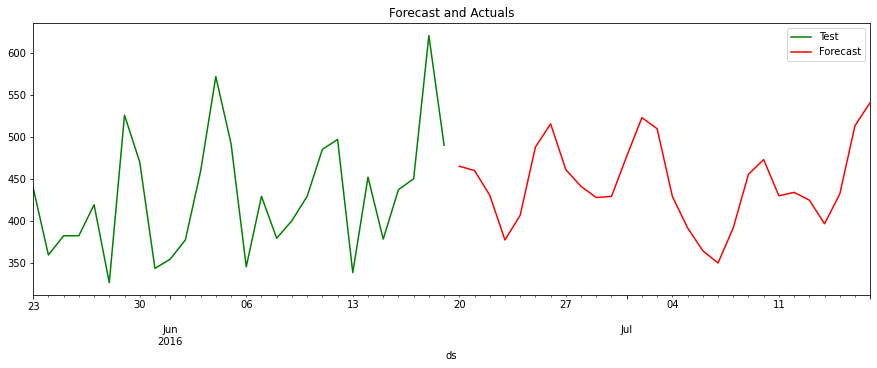

Total Pinball Loss  [0.563445566066547, 0.33088449117329743, 0.8701910196611568, 0.2990113145092704, 1.9354730145900523, 0.09681642358824559, 2.4920167092753167, 0.023039413224084093, 0.39515350873965194]
Avg Pinball Loss  0.778447940091958
RMSSE:  0.767716566023272


In [ ]:
do_the_forecasts_fourier(13,
  changepoint_prior_scale=5,
  seasonality_prior_scale=10,
  holidays_prior_scale= 10,
  seasonality_mode='additive',
  growth='logistic',
  weekly_fourier_order = 3,
  yearly_fourier_order = 120)


# Hobbies_CA_3
# Avg Pinball Loss  0.778447940091958
# RMSSE:  0.767716566023272

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['date', 'Household_1_CA_3']


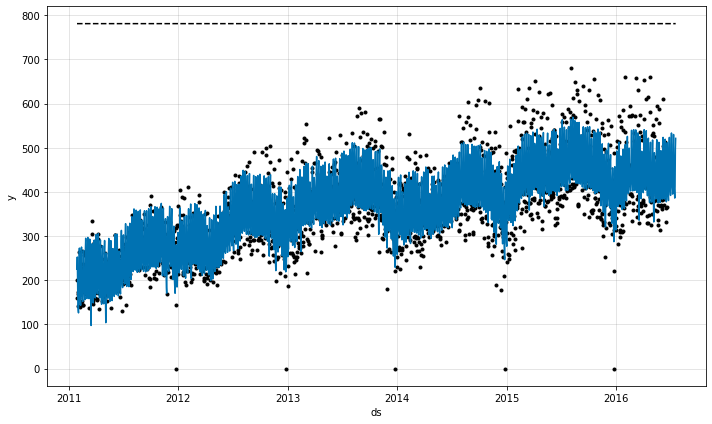

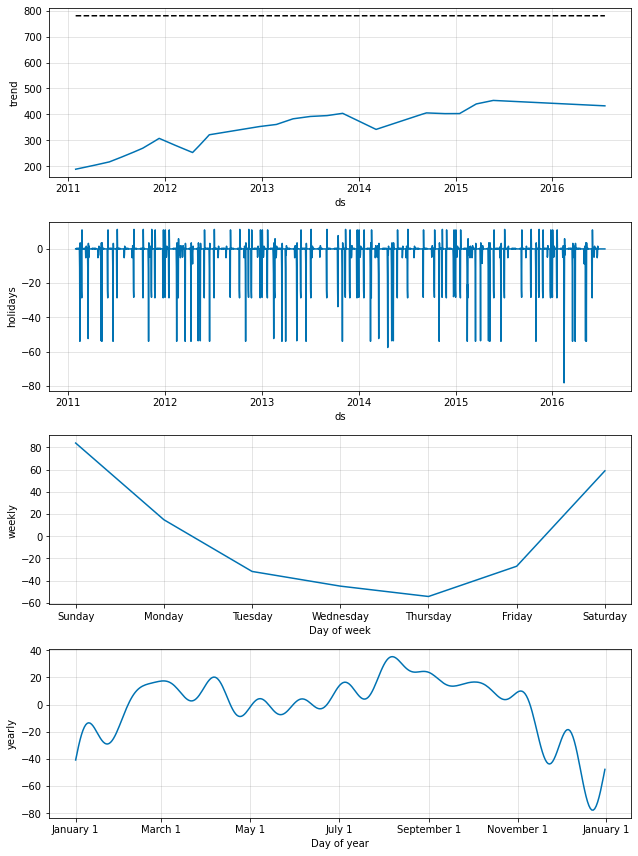

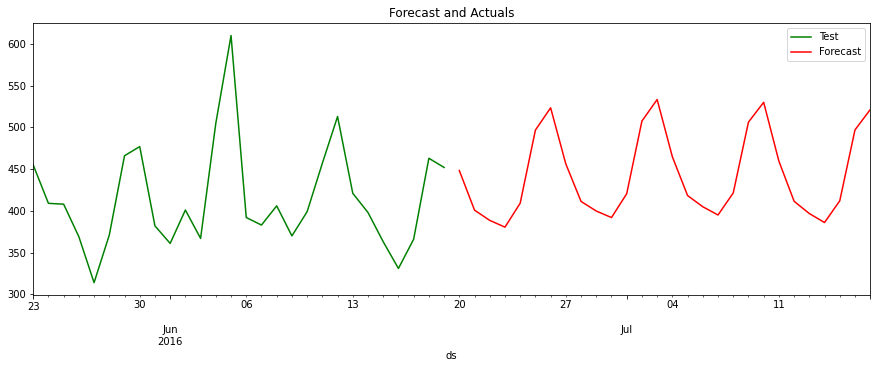

Total Pinball Loss  [0.37888591969194807, 0.34854728491020304, 0.627739021796406, 0.3106667783536829, 1.6028088801004192, 0.09263769692319969, 2.1547988428149645, 0.02501354669305993, 0.2698581337941013]
Avg Pinball Loss  0.6456617894531095
RMSSE:  0.5678999749254436


In [ ]:
do_the_forecasts_fourier(14,
  changepoint_prior_scale=5,
  seasonality_prior_scale=1,
  holidays_prior_scale= 10,
  seasonality_mode='additive',
  growth='logistic',
  weekly_fourier_order = 3,
  yearly_fourier_order = 15)


# Household_1_CA_3
# Avg Pinball Loss  0.6456617894531095
# RMSSE:  0.5678999749254436

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['date', 'Household_2_CA_3']


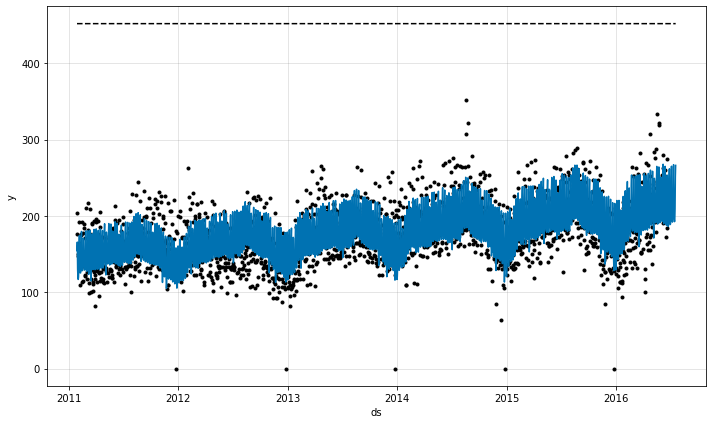

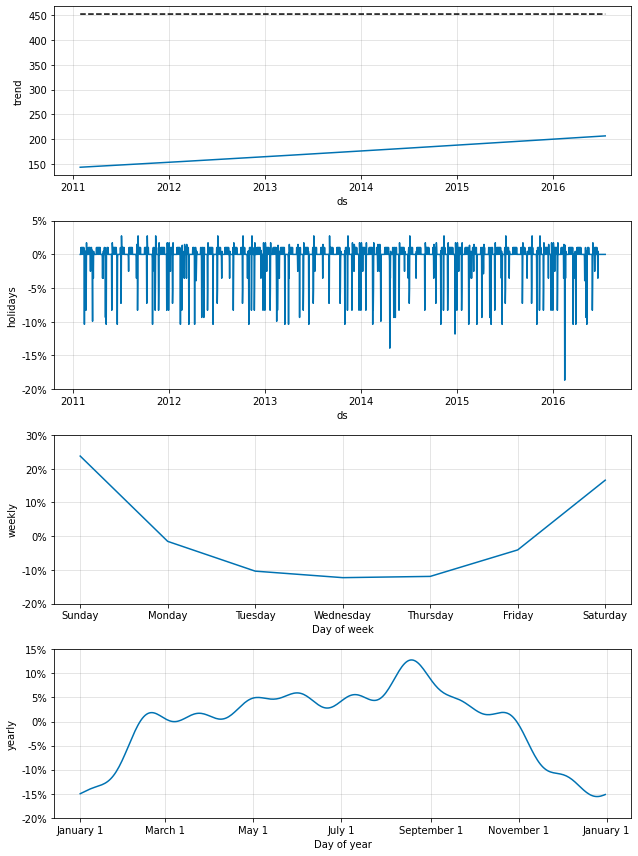

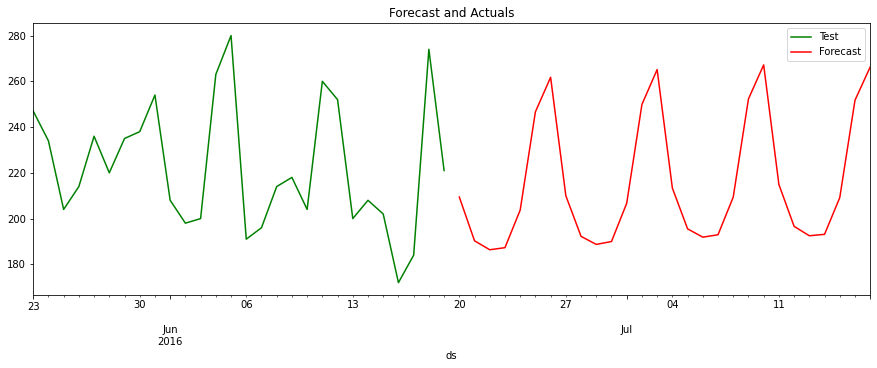

Total Pinball Loss  [1.0281947487095777, 0.4831260531063726, 1.5584184714333327, 0.5077851915320812, 2.9836774344966615, 0.21768976210982696, 3.6622110012138553, 0.05662316737451356, 0.7349846522041467]
Avg Pinball Loss  1.2480789424644856
RMSSE:  1.3196792140651865


In [ ]:
do_the_forecasts(15,
  changepoint_prior_scale=0.005,
  seasonality_prior_scale=1,
  holidays_prior_scale= 10,
  seasonality_mode='multiplicative',
  growth='logistic')


# Household_2_CA_3
# Avg Pinball Loss  1.2480789424644856
# RMSSE:  1.3196792140651865

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['date', 'Foods_1_CA_3']


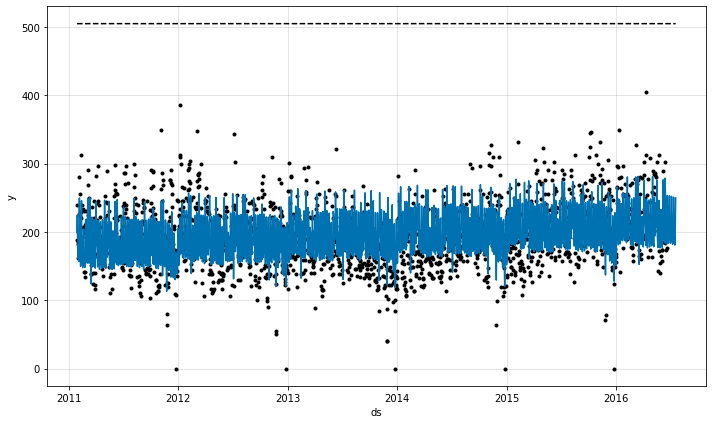

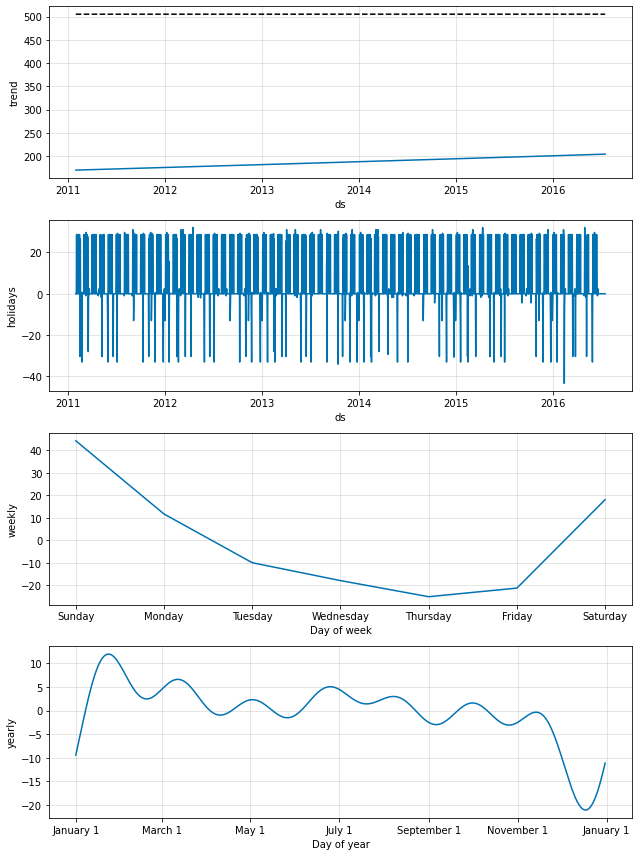

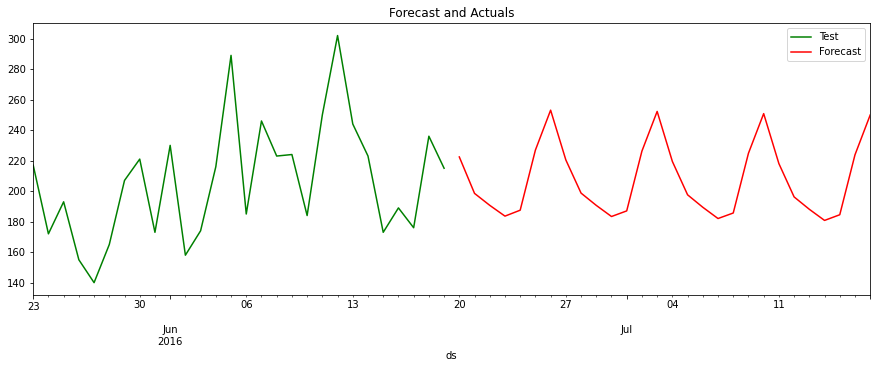

Total Pinball Loss  [0.8632895814287601, 0.34858533623779453, 1.3754405910474428, 0.3031747553376425, 3.0170280909958285, 0.06522244111557417, 3.819253968071514, 0.019222642502205296, 0.5265644064083611]
Avg Pinball Loss  1.1486424236827917
RMSSE:  0.9871228977651147


In [ ]:
do_the_forecasts_fourier(16,
  changepoint_prior_scale=0.005,
  seasonality_prior_scale=10,
  holidays_prior_scale= 1,
  seasonality_mode='additive',
  growth='logistic',
  weekly_fourier_order = 3,
  yearly_fourier_order = 7)


# Foods_1_CA_3
# Avg Pinball Loss  1.1486424236827917
# RMSSE:  0.9871228977651147

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['date', 'Foods_2_CA_3']


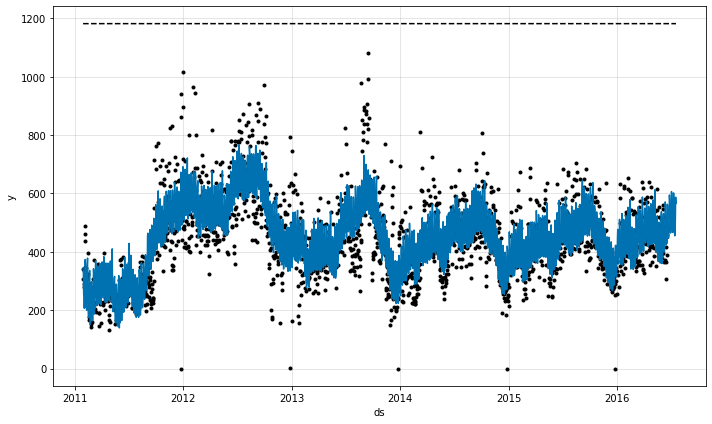

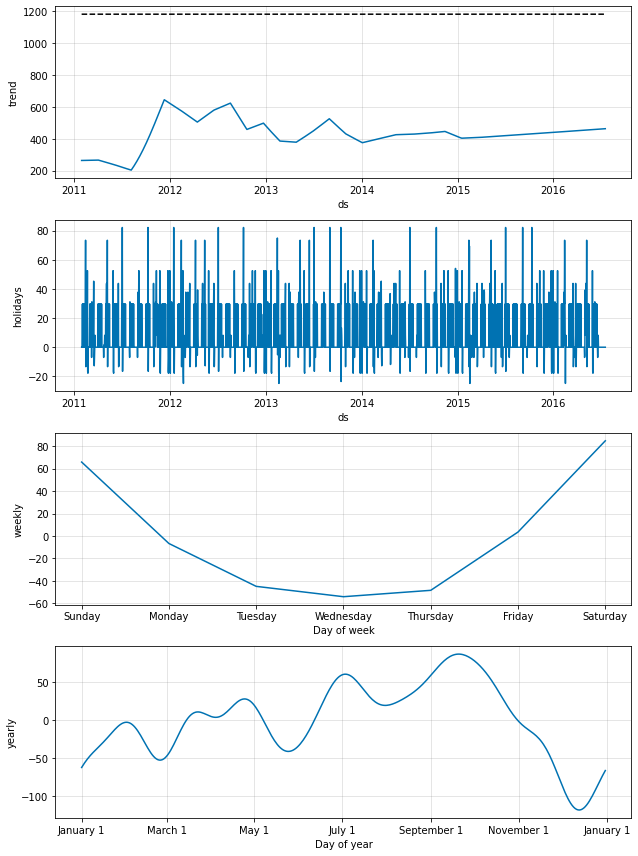

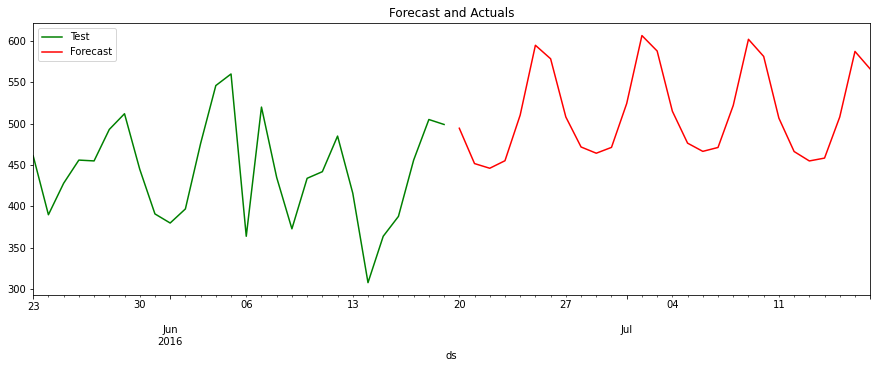

Total Pinball Loss  [1.657194848973321, 0.8502486125745652, 2.4648169081410183, 0.9090950308145115, 4.635375208301741, 0.4656030300630449, 5.537243114249088, 0.17310198744454117, 1.2566211158095533]
Avg Pinball Loss  1.9943666507079318
RMSSE:  1.9307359198429264


In [122]:
do_the_forecasts(17,
  changepoint_prior_scale=5,
  seasonality_prior_scale=1,
  holidays_prior_scale= 0.1,
  seasonality_mode='additive',
  growth='logistic')


# Foods_2_CA_3
# Avg Pinball Loss  1.9943666507079318
# RMSSE:  1.9307359198429264

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['date', 'Foods_3_CA_3']


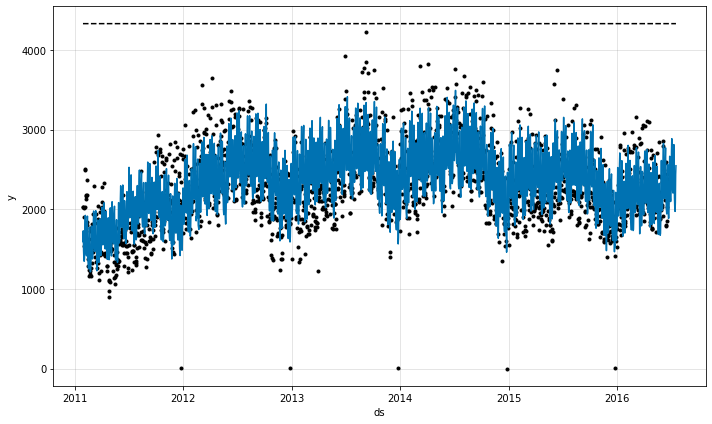

In [ ]:
do_the_forecasts_fourier(18,
  changepoint_prior_scale=0.05,
  seasonality_prior_scale=0.1,
  holidays_prior_scale= 0.1,
  seasonality_mode='multiplicative',
  growth='logistic',
  weekly_fourier_order = 3,
  yearly_fourier_order = 15)


# Foods_3_CA_3
# Avg Pinball Loss  1.8678949245987293
# RMSSE:  1.8911849978259612